# Necessary imports and installations

In [1]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
!pip install spacy-langdetect
!pip install spac scispacy spacy_langdetect https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.3/en_core_sci_lg-0.2.3.tar.gz
!pip install langdetect

     |████████████████████████████████| 3.0 MB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 12.9 MB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 6.2 MB 50.1 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 3.0 MB/s  eta 0:00:01
  Created wheel for scispacy: filename=scispacy-0.2.4-py3-none-any.whl size=35203 sha256=fecc414a6e06501504eff4601708426b4d5f87840355928a9e66550b38f55164
  Stored in directory: /root/.cache/pip/wheels/80/01/69/37a2ab4f9b61773c187d83257ffb31365a5ad57e7779ae5e92
Successfully built scispacy
ERROR: boto3 1.12.32 has requirement botocore<1.16.0,>=1.15.32, but you'll have botocore 1.16.8 which is incompatible.
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.
  Attempting uninstall: botocore
    Found existing installation: botocore 1.15.32
    Uninstalling botocore-1.15.32:
      Successfully uninstalled botocore-1.15.32
  Attempting uninstall: rsa
    Found existi

  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.2.4-py3-none-any.whl size=501343161 sha256=447a316e464708387de07e237e8b4dce7e11cac854f2ac220ccb6f6f9d6625de
  Stored in directory: /root/.cache/pip/wheels/43/12/d5/dd85b5deab7738797c4d5358672df3616dda39acf570a3ef96
Successfully built en-core-sci-lg
     |████████████████████████████████| 998 kB 2.6 MB/s eta 0:00:01
  Created wheel for langdetect: filename=langdetect-1.0.7-py3-none-any.whl size=993461 sha256=7712d1c229066d0468e8cb412bfb087f798351d90f3ee0ee29a9aea1262d81c0
  Stored in directory: /root/.cache/pip/wheels/b7/fc/78/21a8a2e77805c9f5d82a50188f3e10473f7028a470b6a976b1
Successfully built langdetect
     |████████████████████████████████| 499.6 MB 9.8 kB/s eta 0:00:01MB 3.1 MB/s eta 0:00:48█████▌        | 367.5 MB 3.1 MB/s eta 0:00:44
ERROR: Could not find a version that satisfies the requirement spac (from versions: none)
ERROR: No matching distribution found for spac


In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import glob

In [3]:
import scispacy
import spacy
import en_core_sci_lg
from spacy_langdetect import LanguageDetector
from spacy.lang.en.stop_words import STOP_WORDS

In [4]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# Loading MetaData

Loading the data was assisted by [this notebook](https://www.kaggle.com/maksimeren/covid-19-literature-clustering/data#Data-Pre-processing)

In [5]:
root_path = '/kaggle/input/CORD-19-research-challenge/'
metadata_path = '/kaggle/input/CORD-19-research-challenge/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998,green-oa,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/b2897e1277f56641193a6...,document_parses/pmc_json/PMC125340.xml.json,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704,green-oa,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/e3d0d482ebd9a8ba81c25...,document_parses/pmc_json/PMC125375.xml.json,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,document_parses/pdf_json/00b1d99e70f779eb4ede5...,document_parses/pmc_json/PMC125543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723,green-oa,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/cf584e00f637cbd8f1bb3...,document_parses/pmc_json/PMC126080.xml.json,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663,green-oa,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/dde02f11923815e6a16a3...,document_parses/pmc_json/PMC136939.xml.json,http://europepmc.org/articles/pmc136939?pdf=re...


# Loading papers into a DataFrame

Let's start with defning a couple of methods to help us read the data

In [6]:
class FileReader:                                    #found this  online
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'

In [7]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

Loading all JSON files

In [8]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)

We then load our data into a DataFrame

In [9]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    if len(meta_data) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    try:
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        dict_['authors'].append(meta_data['authors'].values[0])
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    dict_['journal'].append(meta_data['journal'].values[0])
    dict_['doi'].append(meta_data['doi'].values[0])
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 85371
Processing index: 8537 of 85371
Processing index: 17074 of 85371
Processing index: 25611 of 85371
Processing index: 34148 of 85371
Processing index: 42685 of 85371
Processing index: 51222 of 85371
Processing index: 59759 of 85371
Processing index: 68296 of 85371
Processing index: 76833 of 85371
Processing index: 85370 of 85371


,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary
0,9448595c55a568f60646f12abccf27cdd8157af6,10.1007/3-7643-7339-3_11,,Disease management as understood here does not...,"Ammon, Andrea",Disease management strategies in SARS,Coronaviruses with Special Emphasis on First I...,Not provided.
1,df00dae042a148c2be3d0d1aa08d75c142f467fa,10.1067/mai.2003.94,The increasing incidence and prevalence of ast...,Despite the marked heterogeneity of the asthma...,"Lemanske, Robert F.. Busse, William W.",6. Asthma()(),J Allergy Clin Immunol,The increasing incidence and prevalence of<br...
2,8de96a8f9151d7cce65f70872e15000a7b78e44b,10.1016/j.jcv.2020.104305,,"The emerging SARS-coronavirus-2 (SARS-CoV-2, p...","Cordes, Anne K.. Heim, Albert",Rapid random access detection of the novel<br...,Journal of Clinical Virology,Not provided.
3,e1d54d1ec033522012a4f994961fec6582c17ce6,10.1016/s0195-5616(92)50130-9,,circumscribed. Multifocal pertains to lesions ...,"Pedersen, Niels C.",Inflammatory Oral Cavity Diseases of the Cat,Veterinary Clinics of North America: Small Ani...,Not provided.
4,252878458973ebf8c4a149447b2887f0e553e7b5,10.1111/jvim.14855,A 5-year-old male castrated Lhasa Apso cross w...,Northern California was evaluated at the Willi...,"Yaemsiri, S.. Sykes, J.E.",Successful Treatment of Disseminated<br>Nocar...,J Vet Intern Med,A 5-year-old male castrated Lhasa Apso cross<...


Let's take a look at our data

In [10]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46394 entries, 0 to 46393
Data columns (total 8 columns):
paper_id            46394 non-null object
doi                 45098 non-null object
abstract            46394 non-null object
body_text           46394 non-null object
authors             45684 non-null object
title               46356 non-null object
journal             41941 non-null object
abstract_summary    46394 non-null object
dtypes: object(8)
memory usage: 2.8+ MB


# Data Cleaning and Pre-Processing

Due to the time constraints, a random sample of the papers will be selected to perform the following steps. We will then drop all null values.

In [11]:
df_covid = df_covid.sample(10000, random_state=42)
df_covid.dropna(inplace=True)

We notice that multiple languages are present in the data. We chose to focus solely on English in order to get better more precise results, keeping in mind that the majority of the papers present are in the English Language.

Dropping all languages other than English. We start by creating a language detector simple model

In [12]:
landetector = en_core_sci_lg.load(disable=["tagger", "ner"])
landetector.max_length = 2000000
landetector.add_pipe(LanguageDetector(), name='language_detector', last=True)

Defining a new column with the language of each paper

In [13]:
df_covid['text_language'] = df_covid.body_text.apply(lambda x: landetector(str(x[:2000]))._.language['language'])

Now let's take a look at the languages of our papers

In [14]:
df_covid.text_language.value_counts()

en       8635
fr         98
es         93
de         30
nl         11
pt          5
it          3
cy          2
zh-cn       1
pl          1
ca          1
Name: text_language, dtype: int64

In [15]:
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,text_language
20987,c86795d38ad8786a1dcfb087f28bcef8424e80b8,10.3382/ps/pez351,Proportions of QX-like genotype infectious bro...,Infectious bronchitis virus (IBV) causes an ac...,"Yan, Shihong. Sun, Yali. Huang, Xiuying. J...",Molecular characteristics and pathogenicity<b...,Poult Sci,Proportions of QX-like genotype infectious<br...,en
26970,48e516e9056814f1541fc337612f0bc649d05536,10.1016/b978-0-12-816331-3.00001-5,,To approach the behavior of viruses acting as ...,"Domingo, Esteban",Chapter 1 Introduction to virus origins and<b...,Virus as Populations,Not provided.,en
13172,7d9f6bae2b7ced5834b4e92e7ef805d85fdea405,10.1371/journal.pntd.0002181,Rift Valley fever virus (RVFV; genus Phlebovir...,"Rift Valley fever virus (RVFV), which belongs ...","Lihoradova, Olga A.. Indran, Sabarish V.. <b...",Characterization of Rift Valley Fever Virus<b...,PLoS Negl Trop Dis,Rift Valley fever virus (RVFV; genus<br>Phleb...,en
36731,8ef466cd0925e7fcbb1be2629a52fb02f4ee91f4,10.1016/j.cyto.2006.10.002,In association with the systemic inflammatory ...,Glycyrrhizin inhibits the manifestations of an...,"Takei, Miwa. Kobayashi, Makiko. Herndon,<br...",Glycyrrhizin inhibits the manifestations of<b...,Cytokine,In association with the systemic inflammatory...,en
10783,789827efa6c04201711d5bca71c97b2e5d63b361,10.1007/978-3-030-33803-9_13,Malaria is intrinsically linked to the Anophel...,Plasmodium spp. are a protozoan parasite that ...,"Hidalgo, Jorge. Arriaga, Pedro. Concejo,<br...",Malaria,Highly Infectious Diseases in Critical Care,Malaria is intrinsically linked to the<br>Ano...,en


Dropping any paper not in English since most of the papers are in English. Much cleaner this way

In [16]:
df_covid = df_covid.drop(df_covid[df_covid.text_language != 'en'].index)

Now all papers left are in English

In [17]:
df_covid.text_language.value_counts()

en    8635
Name: text_language, dtype: int64

The we remove stopwords. Stopwords are words that do not add to the meaning. For this part we will use Spacy's built in predefined topwords along with stopwords commonly used in research papers. These commonly used ones we found on multiple notebooks on Kaggle. [ Example of stopword definition](https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles)

In [18]:
import string

punctuations = string.punctuation
stopwordslist = list(STOP_WORDS)
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]
for word in custom_stop_words:
    if word not in stopwordslist:
        stopwordslist.append(word)
stopwordslist

['above',
 'becomes',
 'eleven',
 'else',
 'but',
 'him',
 'latterly',
 'hers',
 'namely',
 'side',
 'them',
 'twenty',
 'where',
 'itself',
 'seems',
 'used',
 'be',
 'are',
 'something',
 'within',
 '’re',
 'it',
 'six',
 'all',
 'been',
 'everyone',
 'further',
 'noone',
 'just',
 'per',
 'here',
 'third',
 'up',
 'whereafter',
 'herein',
 '‘m',
 'and',
 'us',
 'because',
 'four',
 "'re",
 'why',
 'from',
 'how',
 'a',
 'already',
 'as',
 'various',
 'yours',
 'nothing',
 'for',
 'over',
 'please',
 'anywhere',
 'her',
 'put',
 'nobody',
 'sixty',
 'enough',
 'thereupon',
 'take',
 'very',
 'whether',
 'five',
 'would',
 'can',
 'about',
 'any',
 'more',
 'behind',
 'myself',
 'until',
 'same',
 'the',
 'anything',
 "'d",
 'or',
 'at',
 'everywhere',
 'has',
 "'m",
 'around',
 'me',
 'rather',
 'across',
 'part',
 'while',
 'moreover',
 'they',
 'except',
 'n’t',
 'much',
 'i',
 'after',
 'nevertheless',
 'due',
 'could',
 'not',
 "'ve",
 'many',
 'fifty',
 "'ll",
 'less',
 'beforeh

Then we will tokenize the data utilising our stopwords and using en_core_sci_lg which is a model for processing biomedical, scientific or clinical text. First we define a function to be applied on the body text of each paper entry

In [19]:
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def tokenizer(sentence):
    token = parser(sentence)
    token = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in token ]
    token = [ word for word in token if word not in stopwordslist and word not in punctuations ]
    token = " ".join([i for i in token])
    return token

Then we apply our tokenizer on the body text

In [20]:
tqdm.pandas()
df_covid["tokens"] = df_covid["body_text"].progress_apply(tokenizer)

100%|██████████| 8635/8635 [1:06:03<00:00,  2.18it/s] 


In [21]:
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,text_language,tokens
20987,c86795d38ad8786a1dcfb087f28bcef8424e80b8,10.3382/ps/pez351,Proportions of QX-like genotype infectious bro...,Infectious bronchitis virus (IBV) causes an ac...,"Yan, Shihong. Sun, Yali. Huang, Xiuying. J...",Molecular characteristics and pathogenicity<b...,Poult Sci,Proportions of QX-like genotype infectious<br...,en,infectious bronchitis virus ibv cause acute hi...
26970,48e516e9056814f1541fc337612f0bc649d05536,10.1016/b978-0-12-816331-3.00001-5,,To approach the behavior of viruses acting as ...,"Domingo, Esteban",Chapter 1 Introduction to virus origins and<b...,Virus as Populations,Not provided.,en,approach behavior virus act population ﻿1 exam...
13172,7d9f6bae2b7ced5834b4e92e7ef805d85fdea405,10.1371/journal.pntd.0002181,Rift Valley fever virus (RVFV; genus Phlebovir...,"Rift Valley fever virus (RVFV), which belongs ...","Lihoradova, Olga A.. Indran, Sabarish V.. <b...",Characterization of Rift Valley Fever Virus<b...,PLoS Negl Trop Dis,Rift Valley fever virus (RVFV; genus<br>Phleb...,en,rift valley fever virus rvfv belong family bun...
36731,8ef466cd0925e7fcbb1be2629a52fb02f4ee91f4,10.1016/j.cyto.2006.10.002,In association with the systemic inflammatory ...,Glycyrrhizin inhibits the manifestations of an...,"Takei, Miwa. Kobayashi, Makiko. Herndon,<br...",Glycyrrhizin inhibits the manifestations of<b...,Cytokine,In association with the systemic inflammatory...,en,glycyrrhizin inhibit manifestation anti-inflam...
10783,789827efa6c04201711d5bca71c97b2e5d63b361,10.1007/978-3-030-33803-9_13,Malaria is intrinsically linked to the Anophel...,Plasmodium spp. are a protozoan parasite that ...,"Hidalgo, Jorge. Arriaga, Pedro. Concejo,<br...",Malaria,Highly Infectious Diseases in Critical Care,Malaria is intrinsically linked to the<br>Ano...,en,plasmodium spp protozoan parasite cause malari...


---
# **Clustering**
Clustering with a set of terms related to this task.

---
## **TF-IDF**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

terms= ["Vaccine","Vaccines","therapeutics","drug","drugs","dosing","dose","side effects","treatment","treatments","treat","therapies",
        "pharmaceutical"," mRNA","messenger RNA","antibody","antibodies","immune","Regeneron","PiCoVacc",
        "clinical trials","clinical trial","Antiviral","Antivirals","SARS-CoV-2","placebo-controlled","dose-finding"]

tfidf_terms = TfidfVectorizer(
    max_features = 2**12,
    vocabulary = terms,
    stop_words = 'english'
)
abstract_tfidf_vaccine_terms = tfidf_terms.fit_transform(df_covid['abstract'].values)

In [23]:
abstract_tfidf_vaccine_terms.shape

(8635, 27)

---
## **Clustering**

We will use K-means clustering. First we will find the optimal k using the elbow method.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


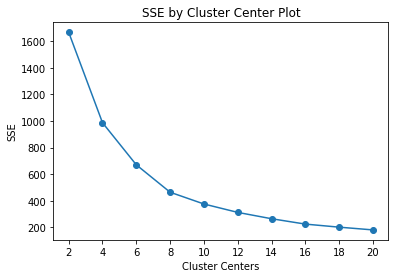

In [24]:
from sklearn.cluster import KMeans

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(KMeans(n_clusters=k, random_state=0).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(abstract_tfidf_vaccine_terms, 20)


From the above graph, k = 8 is chosen.

In [55]:
from sklearn.cluster import KMeans
kmeans_2 = KMeans(n_clusters=8,random_state=0)
pred_y_2 = kmeans_2.fit_predict(abstract_tfidf_vaccine_terms)

In [56]:
from collections import Counter
Counter(pred_y_2)

Counter({0: 6530, 2: 304, 4: 187, 6: 142, 1: 541, 5: 510, 3: 224, 7: 197})

In [57]:
df_covid['cluster_2'] = pred_y_2

In [58]:
df_covid.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,text_language,tokens,cluster_2
20987,c86795d38ad8786a1dcfb087f28bcef8424e80b8,10.3382/ps/pez351,Proportions of QX-like genotype infectious bro...,Infectious bronchitis virus (IBV) causes an ac...,"Yan, Shihong. Sun, Yali. Huang, Xiuying. J...",Molecular characteristics and pathogenicity<b...,Poult Sci,Proportions of QX-like genotype infectious<br...,en,infectious bronchitis virus ibv cause acute hi...,0
26970,48e516e9056814f1541fc337612f0bc649d05536,10.1016/b978-0-12-816331-3.00001-5,,To approach the behavior of viruses acting as ...,"Domingo, Esteban",Chapter 1 Introduction to virus origins and<b...,Virus as Populations,Not provided.,en,approach behavior virus act population ﻿1 exam...,0
13172,7d9f6bae2b7ced5834b4e92e7ef805d85fdea405,10.1371/journal.pntd.0002181,Rift Valley fever virus (RVFV; genus Phlebovir...,"Rift Valley fever virus (RVFV), which belongs ...","Lihoradova, Olga A.. Indran, Sabarish V.. <b...",Characterization of Rift Valley Fever Virus<b...,PLoS Negl Trop Dis,Rift Valley fever virus (RVFV; genus<br>Phleb...,en,rift valley fever virus rvfv belong family bun...,2
36731,8ef466cd0925e7fcbb1be2629a52fb02f4ee91f4,10.1016/j.cyto.2006.10.002,In association with the systemic inflammatory ...,Glycyrrhizin inhibits the manifestations of an...,"Takei, Miwa. Kobayashi, Makiko. Herndon,<br...",Glycyrrhizin inhibits the manifestations of<b...,Cytokine,In association with the systemic inflammatory...,en,glycyrrhizin inhibit manifestation anti-inflam...,0
10783,789827efa6c04201711d5bca71c97b2e5d63b361,10.1007/978-3-030-33803-9_13,Malaria is intrinsically linked to the Anophel...,Plasmodium spp. are a protozoan parasite that ...,"Hidalgo, Jorge. Arriaga, Pedro. Concejo,<br...",Malaria,Highly Infectious Diseases in Critical Care,Malaria is intrinsically linked to the<br>Ano...,en,plasmodium spp protozoan parasite cause malari...,0


To get a better understanding of our clusters, we will see what were the dominant words in each cluster.

In [59]:
import seaborn as sns

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tfidf_terms.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(7, 8))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

In [60]:
tf_idf_2 = pd.DataFrame(data = abstract_tfidf_vaccine_terms.toarray(), columns=tfidf_terms.get_feature_names())
final_df_2 = tf_idf_2
final_df_array_2 = final_df_2.to_numpy()
n_feats = 27

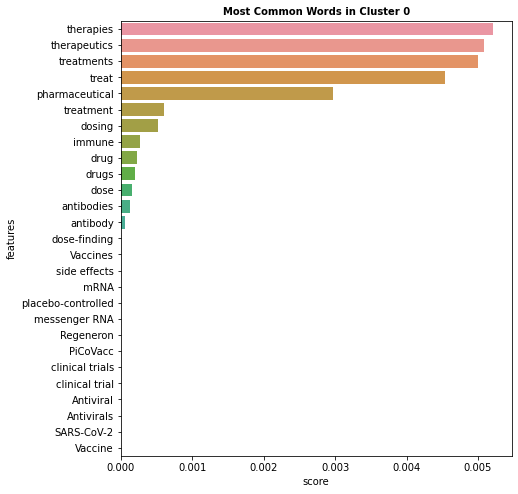

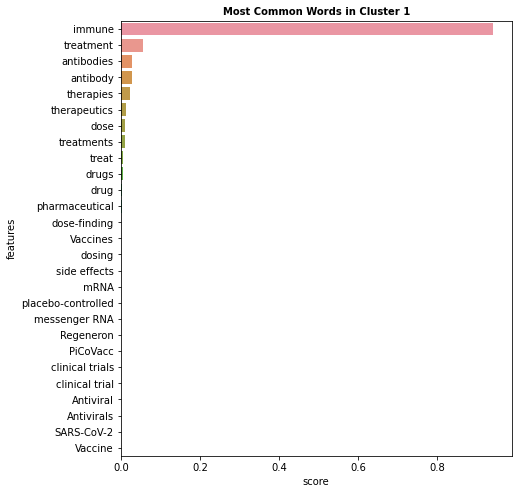

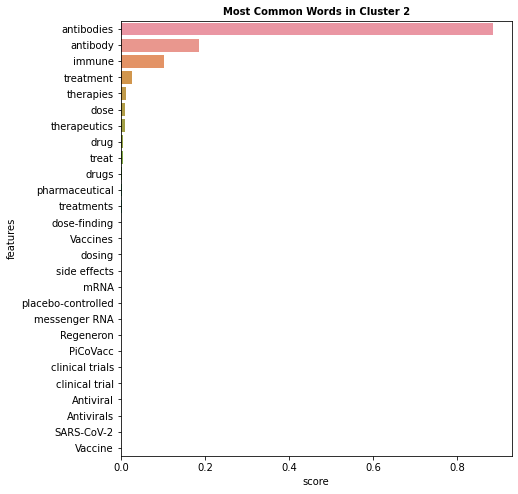

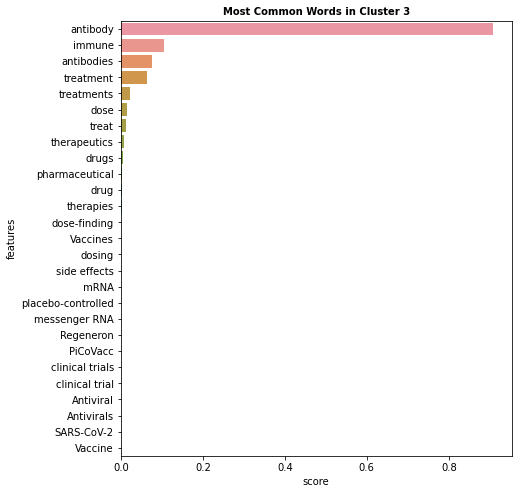

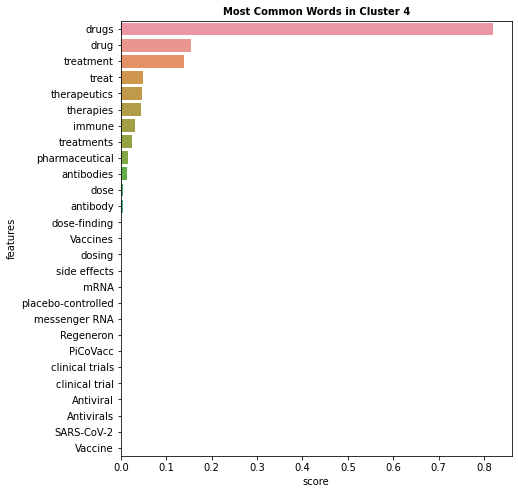

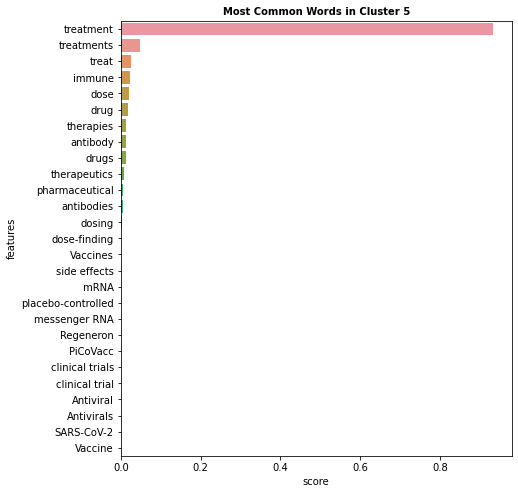

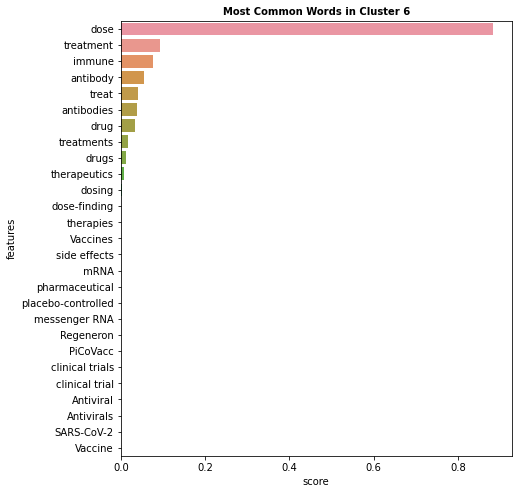

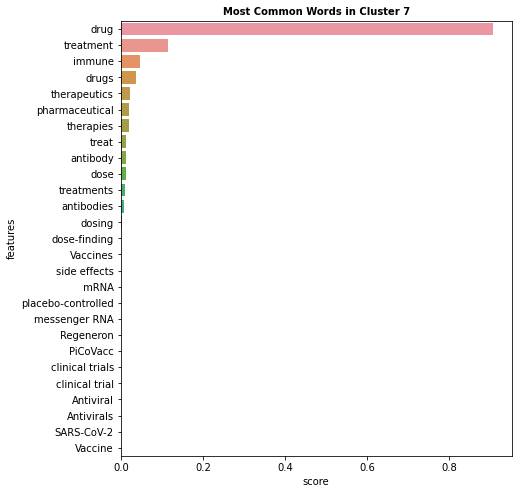

In [61]:
dfs_2 = get_top_features_cluster(final_df_array_2, pred_y_2, n_feats)
plotWords(dfs_2, n_feats)

In order to test the performance of our clustering, we will attempt to use a supervised classification method to predict the labels of the clusters. If the clustering was meaningful, then the performance of the classifier should be high.

First a standard 80:20 train-test split is applied.

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(abstract_tfidf_vaccine_terms.toarray(),df_covid['cluster_2'], test_size=0.2, random_state=42)

We will then use the Stochastic Gradient Descent (SGD) classifier which has a very good performance in similar cases.

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
sgd_clf.fit(X_train, y_train)
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

Measuring the performance on the training set (cross-validation was used).

In [64]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

print('Accuracy: ', accuracy_score(y_train, sgd_pred)*100)
print('Precision: ', precision_score(y_train, sgd_pred, average='macro')*100)
print('Recall: ', recall_score(y_train, sgd_pred, average='macro')*100)
print('F1 Score: ', f1_score(y_train, sgd_pred, average='macro')*100)

Accuracy:  99.56572090330053
Precision:  98.1665383097112
Recall:  98.7947139105368
F1 Score:  98.46270254759308


Finally, to avoid overfitting, the classifier is tested against the test set.

In [65]:
sgd_pred_test = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

In [66]:
print('Accuracy: ', accuracy_score(y_test, sgd_pred_test)*100)
print('Precision: ', precision_score(y_test, sgd_pred_test, average='macro')*100)
print('Recall: ', recall_score(y_test, sgd_pred_test, average='macro')*100)
print('F1 Score: ', f1_score(y_test, sgd_pred_test, average='macro')*100)

Accuracy:  99.47886508396063
Precision:  97.80761363136955
Recall:  98.62522620599985
F1 Score:  98.19032636267477


# Search

We will attempt to find the keywords in each cluster using LDA.

In [67]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [68]:
vectorizers = []

for i in range(0, 8):
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [69]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df_covid.loc[df_covid['cluster_2'] == current_cluster, 'tokens']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [70]:
lda_models = []

for i in range(0, 8):
    lda = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)

In [71]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [72]:
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []

    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])

    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])

    return return_values

In [73]:
all_keywords = []

for current_vectorizer, lda in enumerate(lda_models):
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

all_keywords

[['cell',
  'protein',
  'patient',
  'virus',
  'sequence',
  'study',
  'disease',
  'vaccine',
  'infection',
  'sample',
  'mouse',
  'model',
  'datum',
  'care',
  'cause',
  'health',
  'activity',
  'acid',
  'water',
  'bacterium',
  'air'],
 ['mouse',
  'gene',
  'viral',
  'protein',
  'tlr',
  'group',
  'autophagy',
  'disease',
  'vaccine',
  'patient',
  'sequence',
  'il-',
  'expression',
  'cat',
  'antigen',
  'day',
  'atg',
  'airway',
  'peptide',
  'bind',
  'bacterial',
  'brain',
  'receptor',
  'respiratory',
  'ccl',
  'lectin'],
 ['protein',
  'mouse',
  'serum',
  'sample',
  'assay',
  'sequence',
  'receptor',
  'expression',
  'dog',
  'cat',
  'trimer',
  'disease',
  'bind',
  'residue',
  'patient',
  'detection',
  'fipv',
  'vaccine',
  'bat',
  'dna',
  'gene',
  'contamination',
  'csf',
  'puncture'],
 ['protein',
  'group',
  'virus',
  'patient',
  'serum',
  'sequence',
  'sample',
  'cat',
  'rsv',
  'bind',
  'asthma',
  'outbreak',
  'parti

We will attempt to find the clusters which focus on vaccines. The approach is that the word *vaccine* should appear in the top 5 keywords for a cluster to be included.

In [74]:
def filter_clusters(keywords, top):
    clusters = []
    
    for k in range(0,8):
        for i in range(0,10):
            if(keywords[k][i] == 'vaccine' and i <= (top - 1)):
                clusters.append(k)
                break
    
    return clusters

In [80]:
filtered_clusters = filter_clusters(all_keywords, 5)
filtered_clusters

[4]

We have now identified the cluster most relevant to vaccines. We will now attempt to retrieve the best papers from this cluster using TF-IDF and cosine similarity.

We will drop all documents not in the filtered clusters

In [81]:
filtered = df_covid.loc[df_covid['cluster_2'].isin(filtered_clusters)]
filtered.shape

(187, 11)

We will use the questions posed by this task as the query to compare to the papers in this cluster.

In [82]:
query = ['''Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication. Methods evaluating potential complication of Antibody-Dependent Enhancement in vaccine recipients.Exploration of use of best animal models and their predictive value for a human vaccine. Capabilities to discover a therapeutic for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents. Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need. Efforts targeted at a universal coronavirus vaccine. Efforts to develop animal models and standardize challenge studies. Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers. Approaches to evaluate risk for enhanced disease after vaccination. Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models in conjunction with therapeutics.''']

In [83]:
terms = ["Vaccine","Vaccines","therapeutics","drug","drugs","dosing","dose","side effects","treatment","treatments","treat","therapies",
        "pharmaceutical"," mRNA","messenger RNA","antibody","antibodies","immune","Regeneron","PiCoVacc",
        "clinical trials","clinical trial","Antiviral","Antivirals","SARS-CoV-2","placebo-controlled","dose-finding"]

tfidf_terms = TfidfVectorizer(
    max_features = 2**12,
    vocabulary = terms,
    stop_words = 'english'
)
query_tfidf = tfidf_terms.fit_transform(query)

In [84]:
terms = ["Vaccine","Vaccines","therapeutics","drug","drugs","dosing","dose","side effects","treatment","treatments","treat","therapies",
        "pharmaceutical"," mRNA","messenger RNA","antibody","antibodies","immune","Regeneron","PiCoVacc",
        "clinical trials","clinical trial","Antiviral","Antivirals","SARS-CoV-2","placebo-controlled","dose-finding"]

tfidf_terms = TfidfVectorizer(
    max_features = 2**12,
    vocabulary = terms,
    stop_words = 'english'
)
filtered_tfidf = tfidf_terms.fit_transform(filtered['abstract'].values)

In [85]:
print(query_tfidf.shape)
print(filtered_tfidf.shape)

(1, 27)
(187, 27)


The similarity is found using cosine similarity.

In [86]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(query_tfidf, filtered_tfidf)

In [87]:
filtered['cosine'] = similarity.transpose()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Finally, the result is sorted with the highest similarity being first and the top 5 papers are displayed.

In [88]:
result = filtered.sort_values(by=['cosine'], inplace=False, ascending=False)

In [89]:
result.head()

,paper_id,doi,abstract,body_text,authors,title,journal,abstract_summary,text_language,tokens,cluster_2,cosine
40213,5d119a4cad45a112b332047e35127b78608e5a10,10.1254/jphs.12124fp,System L is a major transport system for cellu...,Amino acid transport across the plasma membran...,"Khunweeraphong, Narakorn. Nagamori, Shushi. ...",Establishment of Stable Cell Lines With High<...,Journal of Pharmacological Sciences,System L is a major transport system for<br>c...,en,amino acid transport plasma membrane mediate a...,4,0.876332
21995,cf3cf4d57a396f2557e1d412e5ebdf06ad6de8f1,10.1016/j.antiviral.2018.11.016,This is the second of two invited articles rev...,This is the second of two invited articles rev...,"Yates, Mary K.. Seley-Radtke, Katherine L.",The evolution of antiviral nucleoside<br>anal...,Antiviral Research,This is the second of two invited articles<br...,en,2 invite article review development nucleoside...,4,0.876332
3064,44ce728e9777a6644404a15f6945116b189f3c17,10.1016/j.antiviral.2019.104651,Emerging coronaviruses (CoVs) primarily cause ...,Coronaviruses (CoVs) are enveloped viruses pos...,"Dong, Wanyu. Xie, Wenting. Liu, Yunbo. Sui...",Receptor tyrosine kinase inhibitors block<br>...,Antiviral Research,Emerging coronaviruses (CoVs) primarily<br>ca...,en,coronaviruses covs envelop virus possess singl...,4,0.876332
43818,cfac94a5aef35458836c0bc9e66cb57fbcf09e65,10.1038/nrg1892,The cellular role of DNA is relatively limited...,"DNA sequences that have been designed, using m...","Condon, Anne",Designed DNA molecules: principles and<br>app...,Nat Rev Genet,The cellular role of DNA is relatively limite...,en,dna sequence design use manual computational m...,4,0.876332
30637,4edda548e89522b4df20e723e29c63f309857b10,10.1128/mbio.00165-13,A novel human coronavirus (HCoV-EMC) was recen...,partially explaining the large host range of H...,"Josset, Laurence. Menachery, Vineet D.. <br>...",Cell Host Response to Infection with Novel<br...,mBio,A novel human coronavirus (HCoV-EMC) was<br>r...,en,partially explain large host range hcov-emc so...,4,0.876332


---
# **Citations and References **

> [Some of the loading and preprocessing processes ](https://www.kaggle.com/danielwolffram/cord-19-create-dataframe/data#Load-Packages)

> @inproceedings{COVID-19 Literature Clustering,
    author = {Eren, E. Maksim. Solovyev, Nick. Nicholas, Charles. Raff, Edward},
    title = {COVID-19 Literature Clustering},
    year = {2020},
    month = {April},
    location = {University of Maryland Baltimore County (UMBC), Baltimore, MD, USA},
    note={Malware Research Group},
    url = {\url{https://github.com/MaksimEkin/COVID19-Literature-Clustering}},
    howpublished = {TBA}
} 